# Overview



Hey everyone, I'm **Kevin**! Welcome to my deep learning project, where I've been exploring **Convolutional Neural Networks** (CNNs) for image classification on **CIFAR-10** and **CIFAR-100**. Here's a quick rundown:

## 🚧Task & Datasets
- Built and fine-tuned a CNN on **CIFAR-10** and **CIFAR-100** for image classification.  
- Used data augmentation (random crop, horizontal flip, color jitter) to improve generalization.

## ⚙️Model Architecture
- Integrated **residual connections** for deeper, more robust feature learning.  
- Included **dropout** and **batch normalization** to reduce overfitting and stabilize training.  
- Applied **learning rate scheduling** for optimized convergence.

## 📈Performance & Fine-Tuning
- Achieved competitive accuracy through systematic training and validation.  
- Fine-tuned on CIFAR-100 by reusing learned weights from CIFAR-10.

## 🔍Model Interpretability
- Employed **Grad-CAM** to visualize the CNN's decision-making process.  
- Displayed **feature maps** to reveal how each layer interprets and transforms input images.

## 🎯Key Takeaways
- Combining **residual connections**, **dropout**, **batch normalization**, and **data augmentation** leads to better performance.  
- **Grad-CAM** and **feature map** visualization provide valuable insights into how the network perceives images.

Thanks for stopping by! ✨


# 1. Data Loading & Augmentation

## 1.1 Loading Data and Calculating Mean and Std

In deep learning, normalizing image data helps speed up network convergence and improve numerical stability. This code snippet iterates through the dataset to calculate the per-channel mean and standard deviation for CIFAR-10, providing consistent parameters for subsequent data normalization.

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False)

mean = torch.zeros(3)
sqr_mean = torch.zeros(3)
count = 0

for images, _ in loader:
    # The shape of images is [batch_size, 3, 32, 32]
    batch_size = images.size(0)
    # Flatten the spatial dimension
    images = images.view(batch_size, 3, -1)
    # Accumulate the sum and sum of squares
    mean += images.mean(dim=[0, 2]) * batch_size
    sqr_mean += (images**2).mean(dim=[0, 2]) * batch_size
    count += batch_size

# Compute the overall mean
mean /= count
sqr_mean /= count
# Compute variance = E[x^2] - (E[x])^2
var = sqr_mean - mean**2
std = torch.sqrt(var)

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


## 1.2 Data Augmentation

This section addresses the Advanced Features requirement for “Effective use of data augmentation.” In the training set, we apply various augmentations (random crop, horizontal flip, color jitter) to increase data diversity and reduce overfitting risk. For the test set, we only apply normalization to ensure consistency. These design choices, based on both literature and practical experience, effectively boost model performance on CIFAR-10 and CIFAR-100.

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Random crop 32x32 with 4-pixel padding
    transforms.RandomHorizontalFlip(),         # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],    # CIFAR-10 mean
                         std=[0.2470, 0.2435, 0.2616])     # CIFAR-10 std
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

# Load CIFAR-10 dataset
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Load CIFAR-100 dataset for further fine-tuning
train_set_100 = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=train_transform
)
test_set_100 = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=test_transform
)
train_loader_100 = torch.utils.data.DataLoader(train_set_100, batch_size=128, shuffle=True)
test_loader_100 = torch.utils.data.DataLoader(test_set_100, batch_size=128, shuffle=False)


# 2. Residual Network Structure (Residual Blocks & CNN Model)

To meet the Architecture Complexity requirement, we build a CNN with more than five convolutional layers, integrating Dropout, Batch Normalization, and Residual Connections. This design achieves sufficient depth while mitigating the vanishing gradient issue and improving generalization.

Design Decisions: We use a ResidualBlock and incorporate dropout to enhance the trainability of a deep network and reduce overfitting.

Future Improvement: Consider deeper layers or a bottleneck structure to further increase the network's representational capacity.



In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.shortcut = nn.Sequential()
        # If the dimension changes, use 1x1 conv to match the shortcut
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CNN_Model(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual block: 64->64 channels (same resolution)
        self.layer1 = ResidualBlock(64, 64, stride=1, dropout_prob=0.1)
        # Residual block: 64->128 channels (stride=2 downsample)
        self.layer2 = ResidualBlock(64, 128, stride=2, dropout_prob=0.1)
        # Residual block: 128->128 channels (same resolution)
        self.layer3 = ResidualBlock(128, 128, stride=1, dropout_prob=0.1)
        # Residual block: 128->256 channels (stride=2 downsample)
        self.layer4 = ResidualBlock(128, 256, stride=2, dropout_prob=0.1)
        # Residual block: 256->256 channels
        self.layer5 = ResidualBlock(256, 256, stride=1, dropout_prob=0.1)
        # Global average pooling + fully-connected layer
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.global_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes=10).to(device)
print(model)


CNN_Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (shortcut): Sequential()
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2

# 3. Training & Evaluation

## 3.1 Training the Model


This code snippet demonstrates how to use CrossEntropyLoss, Adam optimizer, and a ReduceLROnPlateau learning rate scheduler. It addresses the Advanced Features requirement for effective learning rate scheduling. We track the training and validation loss/accuracy at each epoch to evaluate model convergence and save the best-performing model weights (best_model.pth).

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 20
best_acc = 0.0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Accumulate training loss and correct predictions
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validate on the test set
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Print results per epoch
    print(f"Epoch {epoch}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss=1.3961, Train Acc=0.4895, Val Loss=1.1330, Val Acc=0.5927
Epoch 2: Train Loss=0.9459, Train Acc=0.6632, Val Loss=1.0311, Val Acc=0.6594
Epoch 3: Train Loss=0.7514, Train Acc=0.7365, Val Loss=0.7575, Val Acc=0.7369
Epoch 4: Train Loss=0.6338, Train Acc=0.7790, Val Loss=0.7788, Val Acc=0.7419
Epoch 5: Train Loss=0.5604, Train Acc=0.8059, Val Loss=0.7769, Val Acc=0.7564
Epoch 6: Train Loss=0.5085, Train Acc=0.8245, Val Loss=0.6378, Val Acc=0.7944
Epoch 7: Train Loss=0.4600, Train Acc=0.8405, Val Loss=0.5682, Val Acc=0.8169
Epoch 8: Train Loss=0.4230, Train Acc=0.8543, Val Loss=0.4442, Val Acc=0.8509
Epoch 9: Train Loss=0.3927, Train Acc=0.8652, Val Loss=0.5188, Val Acc=0.8316
Epoch 10: Train Loss=0.3622, Train Acc=0.8748, Val Loss=0.4362, Val Acc=0.8598
Epoch 11: Train Loss=0.3376, Train Acc=0.8825, Val Loss=0.5281, Val Acc=0.8385
Epoch 12: Train Loss=0.3183, Train Acc=0.8888, Val Loss=0.3999, Val Acc=0.8673
Epoch 13: Train Loss=0.2972, Train Acc=0.8972, Val Loss=0.513

## 3.2 Evaluating the model

To address Performance Metrics by providing a detailed analysis of results, we compute Accuracy, Precision, Recall, and F1-score on the test set, as well as a Confusion Matrix. This allows us to identify which classes are frequently misclassified and plan improvements accordingly.

In [22]:
import numpy as np

# Load the best model weights for test evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Compute precision, recall, and F1-score (macro average)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
conf_mat = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")
print("Confusion Matrix:\n", conf_mat)


Test Accuracy: 89.07%
Precision: 89.30%, Recall: 89.07%, F1-score: 88.98%
Confusion Matrix:
 [[878   6  52   4   4   1   6   2  40   7]
 [  5 968   0   0   1   1   1   0  10  14]
 [ 14   0 864  19  25  34  28   3   8   5]
 [  6   2  33 686  31 175  29  14  14  10]
 [  2   1  22   8 918   9  15  16   9   0]
 [  3   0  24  36  24 891   6   8   6   2]
 [  6   0  23  13  11  11 931   1   3   1]
 [  7   0  14   8  32  27   2 904   2   4]
 [ 22   6   4   2   0   1   4   0 956   5]
 [ 11  56   3   2   0   0   0   2  15 911]]


## 3.3 Fine-Tuning on CIFAR-100


This code snippet demonstrates how to fine-tune a model pretrained on CIFAR-10 for CIFAR-100. We skip the incompatible fully connected layer and reuse the learned convolutional features, fulfilling the Architecture Complexity and Advanced Features requirements.

Future Improvement: Freeze more layers or apply different learning rates to specific layers to optimize fine-tuning further.

In [23]:
# Build a new model for CIFAR-100 (100 classes)
model_100 = CNN_Model(num_classes=100).to(device)

# Load the pretrained state dictionary
pretrained_dict = torch.load("best_model.pth")

# Filter out the fc layer parameters (due to dimension mismatch)
filtered_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith("fc.")}

# Load the filtered parameters
model_100.load_state_dict(filtered_dict, strict=False)

# Optional: freeze certain layers, such as the first two residual blocks
# for param in list(model_100.conv1.parameters()) + list(model_100.layer1.parameters()) + list(model_100.layer2.parameters()):
#     param.requires_grad = False

# Loss and optimizer (using a smaller learning rate for fine-tuning)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_100.parameters(), lr=0.0005)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model_100.train()
    for images, labels in train_loader_100:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_100(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Simple accuracy check at the end of each epoch
    model_100.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader_100:
            images, labels = images.to(device), labels.to(device)
            outputs = model_100(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = correct / total
    print(f"Epoch {epoch} - CIFAR100 Val Acc: {acc:.4f}")


Epoch 1 - CIFAR100 Val Acc: 0.4069
Epoch 2 - CIFAR100 Val Acc: 0.4984
Epoch 3 - CIFAR100 Val Acc: 0.5447
Epoch 4 - CIFAR100 Val Acc: 0.5693
Epoch 5 - CIFAR100 Val Acc: 0.5856
Epoch 6 - CIFAR100 Val Acc: 0.6029
Epoch 7 - CIFAR100 Val Acc: 0.6104
Epoch 8 - CIFAR100 Val Acc: 0.6201
Epoch 9 - CIFAR100 Val Acc: 0.6409
Epoch 10 - CIFAR100 Val Acc: 0.6415


# 4. Model Interpretability with Grad-CAM

## 4.1 Grad-CAM visualizations

Explanation
To meet the Advanced Features requirement for “model interpretability,” this code snippet implements Grad-CAM and visualizes the heatmap. By capturing both activations and gradients of a target layer, it calculates the Class Activation Map (CAM) and overlays it onto the original image, helping us see which regions the model focuses on.

Design Decisions: We choose model.layer5.bn2 as the “last convolutional layer” approximation.

Performance Evaluation: Though Grad-CAM does not directly improve accuracy, it aids in understanding model behavior and guiding future refinements.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


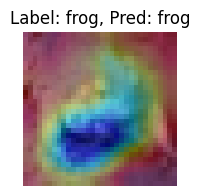

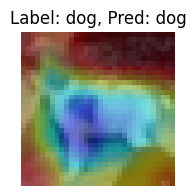

In [24]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def generate_gradcam(model, image_tensor, target_class):
    model.eval()
    image_tensor = image_tensor.to(device)

    activation = None
    gradient = None

    def forward_hook(module, inp, out):
        nonlocal activation
        activation = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_out[0]

    handle_forward = model.layer5.bn2.register_forward_hook(forward_hook)
    handle_backward = model.layer5.bn2.register_backward_hook(backward_hook)

    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    outputs = model(image_tensor)
    pred_class = outputs.argmax().item()
    class_idx = target_class if target_class is not None else pred_class

    model.zero_grad()
    one_hot = torch.zeros_like(outputs)
    one_hot[0, class_idx] = 1
    outputs.backward(gradient=one_hot)

    activation = activation.squeeze(0)
    gradient = gradient.squeeze(0)

    if activation.ndim == 3 and activation.shape[0] != gradient.shape[0]:
        activation = np.transpose(activation.cpu().data.numpy(), (2, 0, 1))
        gradient = np.transpose(gradient.cpu().data.numpy(), (2, 0, 1))
    else:
        activation = activation.cpu().data.numpy()
        gradient = gradient.cpu().data.numpy()

    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))
    cam -= cam.min()
    cam = cam / (cam.max() + 1e-8)

    handle_forward.remove()
    handle_backward.remove()

    cam_uint8 = np.uint8(cam * 255)
    return cam_uint8, pred_class

samples = [5, 12]
model.load_state_dict(torch.load("best_model.pth"))
for idx in samples:
    img, label = test_set[idx]
    cam, pred = generate_gradcam(model, img, target_class=None)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    inv_norm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
        std=[1/s for s in [0.2470, 0.2435, 0.2616]]
    )
    img_denorm = inv_norm(img).permute(1, 2, 0).numpy()
    img_denorm = np.clip(img_denorm, 0, 1)

    overlay = cv2.addWeighted(np.uint8(img_denorm * 255), 0.6, heatmap, 0.4, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(2, 2))
    plt.imshow(overlay_rgb)
    plt.title(f"Label: {test_set.classes[label]}, Pred: {test_set.classes[pred]}")
    plt.axis('off')
    plt.show()


## 4.2 Visualize the feature maps from the convolutional layers

This code snippet visualizes the feature maps from multiple layers in the network by performing partial forward passes for each specific layer (conv1, layer1, layer2, etc.). For each call, it processes the input through the relevant layers up to the one of interest, retrieves the resulting feature maps, and displays a few of their channels. This approach allows inspection of how the network progressively transforms the input at different stages.

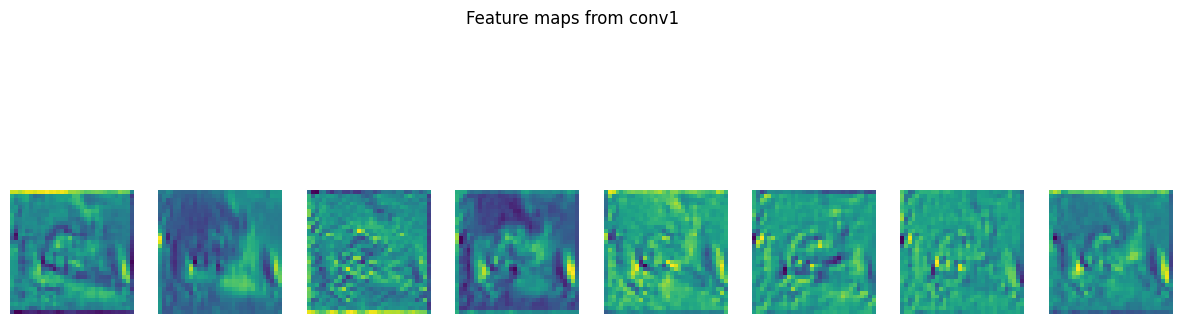

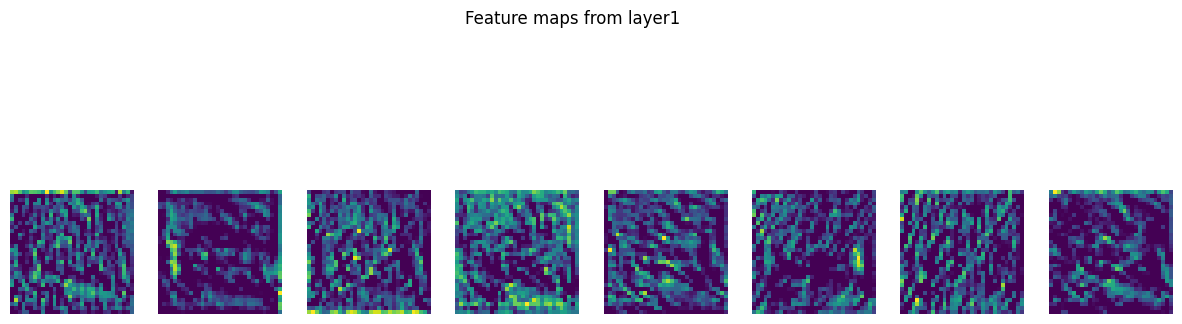

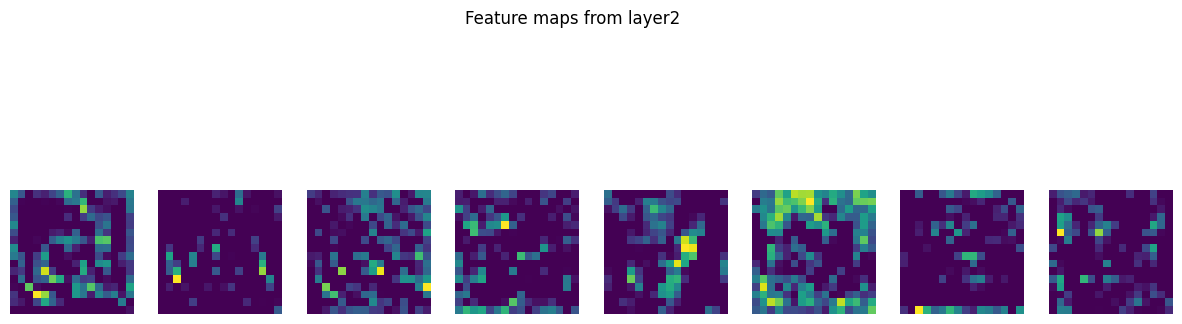

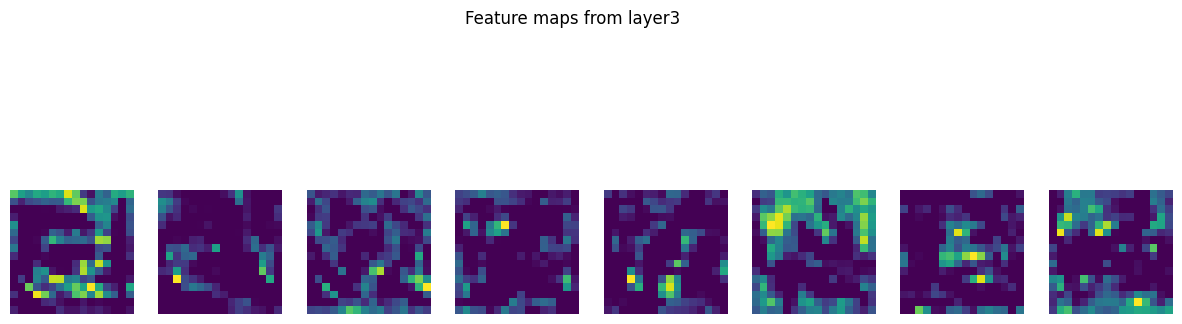

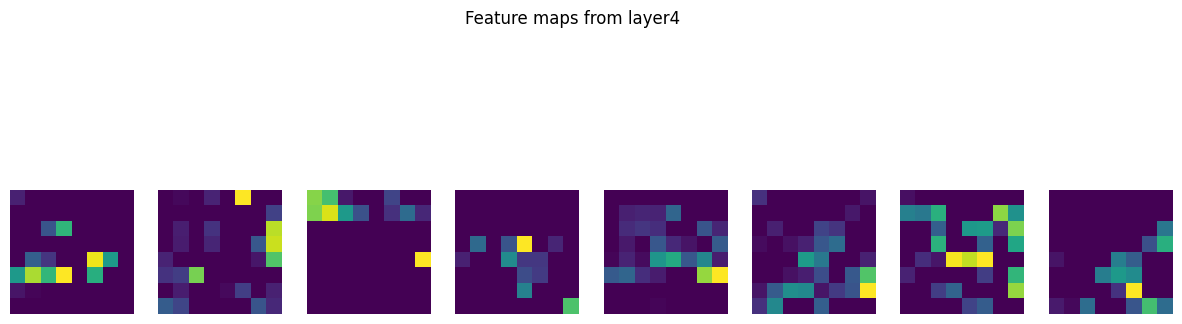

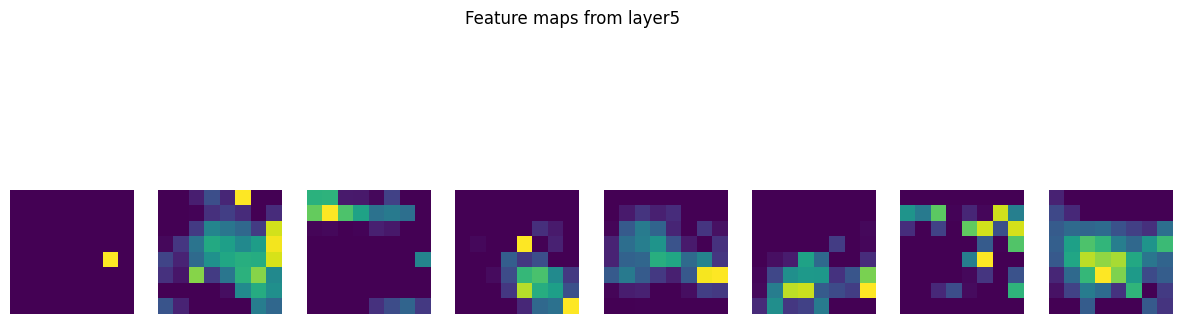

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image_tensor, layer_name="conv1"):
    model.eval()
    with torch.no_grad():
        # Expand dims to (1, C, H, W) for batch processing
        x = image_tensor.unsqueeze(0).to(device)

        # Run a partial forward pass to get the output of the specified layer
        if layer_name == "conv1":
            out = model.conv1(x)
        elif layer_name == "layer1":
            out = model.layer1(model.relu(model.bn1(model.conv1(x))))
        elif layer_name == "layer2":
            # Pass through conv1 -> bn1 -> relu -> layer1 -> layer2
            o1 = model.relu(model.bn1(model.conv1(x)))
            o2 = model.layer1(o1)
            out = model.layer2(o2)
        elif layer_name == "layer3":
            o1 = model.relu(model.bn1(model.conv1(x)))
            o2 = model.layer1(o1)
            o3 = model.layer2(o2)
            out = model.layer3(o3)
        elif layer_name == "layer4":
            o1 = model.relu(model.bn1(model.conv1(x)))
            o2 = model.layer1(o1)
            o3 = model.layer2(o2)
            o4 = model.layer3(o3)
            out = model.layer4(o4)
        elif layer_name == "layer5":
            o1 = model.relu(model.bn1(model.conv1(x)))
            o2 = model.layer1(o1)
            o3 = model.layer2(o2)
            o4 = model.layer3(o3)
            o5 = model.layer4(o4)
            out = model.layer5(o5)
        else:
            raise ValueError(f"Layer {layer_name} not recognized.")

        # out shape: (1, C, H, W)
        feature_maps = out.squeeze(0).cpu().numpy()  # shape: (C, H, W)

    num_maps = feature_maps.shape[0]
    plt.figure(figsize=(15, 5))
    # Show up to 8 channels
    for i in range(min(num_maps, 8)):
        plt.subplot(1, 8, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature maps from {layer_name}")
    plt.show()

# Example calls: visualize feature maps from multiple layers
visualize_feature_maps(model, test_set[5][0], layer_name="conv1")
visualize_feature_maps(model, test_set[5][0], layer_name="layer1")
visualize_feature_maps(model, test_set[5][0], layer_name="layer2")
visualize_feature_maps(model, test_set[5][0], layer_name="layer3")
visualize_feature_maps(model, test_set[5][0], layer_name="layer4")
visualize_feature_maps(model, test_set[5][0], layer_name="layer5")


# 5. Conclusions

## 5.1 Final Results and Analysis


### CIFAR-10
- **Training Progress**  
  - By Epoch 20, the model achieves a validation accuracy of **87.28%** and ends up with a **test accuracy of 89.07%**.  
  - Throughout training, the network steadily improves its accuracy while reducing loss, indicating stable convergence with the chosen architecture and hyperparameters.

- **Performance Metrics**  
  - Precision, Recall, and F1-score all hover around **89%**, suggesting balanced performance across classes.  
  - The confusion matrix reveals that most classes are accurately classified, though certain categories—especially those with visually similar features—occasionally get misclassified. This points to potential avenues for targeted improvement, such as more refined data augmentation or specialized class-wise training strategies.

### CIFAR-100
- **Fine-Tuning and Accuracy Growth**  
  - Starting at **40.69%** validation accuracy, the model reaches **64.15%** by Epoch 10. This demonstrates the effectiveness of transfer learning from CIFAR-10 to CIFAR-100, leveraging learned features and reducing training time.  
  - While **64.15%** accuracy is respectable given the complexity and fine-grained nature of CIFAR-100, there is still room for improvement.

- **Challenges and Next Steps**  
  - The significantly lower accuracy on CIFAR-100 compared to CIFAR-10 highlights the difficulty of distinguishing 100 classes with subtle differences.  
  - Potential enhancements include freezing more layers to preserve low-level features, using layer-wise learning rate schedules, or adopting deeper architectures like larger ResNet variants.

Overall, these results confirm that **residual connections, dropout, batch normalization, data augmentation, and learning rate scheduling** effectively boost the model’s performance on both CIFAR-10 and CIFAR-100. The **Grad-CAM** and **feature map** visualizations further demonstrate how the network processes images and helps identify areas for refinement.

## 5.2 Detailed Explanation of Feature Maps and Grad-CAM Visualizations


1. **Conv1**  
   - At the initial convolution layer, feature maps primarily capture low-level patterns such as edges, corners, and basic color gradients. These serve as fundamental building blocks for higher-level representations in subsequent layers.

2. **Layer1**  
   - After the first residual block, the feature maps begin to combine and refine edge information into clearer textures or shapes. While still focusing on relatively local features (e.g., repeating patterns or oriented lines), they exhibit more structure than those in `conv1`.

3. **Layer2**  
   - At this stage, the network starts detecting more complex structures. With a larger receptive field, the feature maps may capture combined edge and texture information that begins to hint at object parts (like limbs or faces), though not yet forming a complete concept of the object.

4. **Layer4**  
   - Deeper in the network, feature maps become increasingly selective and spatially sparse. The model zeroes in on critical cues that help differentiate classes, often highlighting key regions of the object (e.g., an animal's head or a car's wheels).

5. **Layer5**  
   - In the deepest residual block, feature maps are highly abstract and more class-specific, responding strongly to distinctive structures or configurations. Even channels that appear “blank” may only activate under very specific, telling patterns.

Meanwhile, **Grad-CAM** shows which regions the model focuses on when making its final prediction:
- If the prediction is correct (e.g., “dog” → “dog”), the heatmap typically highlights essential parts of the object (like the dog's face).  
- If the prediction is incorrect (e.g., “dog” → “frog”), the highlighted region may reveal that the model latched onto misleading or background cues, leading to misclassification.

Overall, these visualizations confirm that the network transitions from broad, low-level feature extraction in early layers to more selective, high-level representations in deeper blocks. **Grad-CAM** further illustrates how these learned features guide classification decisions, emphasizing the importance of both local details and global context in image recognition.
